# AB Test gaming experiment

## Data

Data is composed of two datasets, which contains information on players of a game. Some of them have been exposed to a new feature and some are not. First thing, after importing the data it is important to do some checks on it. Especially on the $\textbf{assignment}$ table since it contains the relevant information for the A/B test 

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%%bigquery assignment
SELECT
  *
FROM
  `king-ds-recruit-candidate-722.abtest.assignment`

Downloading: 100%|██████████| 10331056/10331056 [00:08<00:00, 1167479.20rows/s]


In [ ]:
%%bigquery activity
SELECT
  playerid, activity_date, gameends
FROM
  `king-ds-recruit-candidate-722.abtest.activity`

Downloading: 100%|██████████| 214878701/214878701 [03:18<00:00, 1080763.03rows/s]


### Assignment table
Check for the number of players per group, 80% should be in the *control* group and 20% in the *experiment* group 

In [ ]:
assignment['abtest_group'].value_counts()

A    8265610
B    2065446
Name: abtest_group, dtype: int64

In [ ]:
counts = assignment['playerid'].value_counts(ascending=False)
multi_players = counts[counts > 1].count()

print(f'There are {multi_players} players that appear multiple times in the dataset')

There are 0 players that appear multiple times in the dataset


## Hypotesis definition
Players are divided in two groups, the first one *A* represents the players that are not exposed to the new experience, while the group *B* is. These represent the *independent variable*, while the dependant one is actually the conversion rate; This rate defines per each group the average of conversion from non-paying players to paying ones. 

In order to work on the analysis it is necessary to formulate an hypothesis to start from. 

$ H_0 : p = p_0 \\
H_\alpha : p \neq p_0 $ 

Where $p$ and $p_0$ represent the conversion rates for group B that is exposed to the new experience and group A where the experience is kept as is.
The *$\alpha$* value is the threshold by which “if the probability of observing a result as extreme or more (*p-value*) is lower than α, then we reject the Null hypothesis”. Since our $\alpha$=0.05, our confidence *$(1 — \alpha)$* which comes with a probability of 95%

Now in order to calculate the convertion rate I define $\textbf{is_conv}$ to differentiate player that actually have made a purchase on the game from the others.

In [ ]:
assignment['is_conv']=assignment['conversion_date'].apply(lambda x: 0 if x == None else 1)
assignment

,playerid,abtest_group,assignment_date,install_date,conversion_date,is_conv
0,5370700,A,2017-05-04,2016-02-23,None,0
1,9408908,A,2017-05-04,2016-04-03,None,0
2,23812260,A,2017-05-04,2016-08-25,None,0
3,24880261,A,2017-05-04,2016-09-05,None,0
4,12984448,A,2017-05-04,2016-05-09,None,0
...,...,...,...,...,...,...
10331051,51035663,B,2017-05-22,2017-05-22,None,0
10331052,51057557,B,2017-05-22,2017-05-22,None,0
10331053,51103633,B,2017-05-22,2017-05-22,None,0
10331054,51069293,B,2017-05-22,2017-05-22,None,0


## Results visualization
As a first approach to visualizing the results it is important to calculate some basic statistics to get an idea of how the groups look like.

In [ ]:
conversion_rates = assignment.groupby('abtest_group')['is_conv']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
abtest_group,,,
A,0.028,0.164,0.000
B,0.028,0.164,0.000


Looking at the stats, it looks like the two 'experiences' performed the same. Conversion rates are the same and as for the standard error equal to zero, we get that this sample statistics are sa accurate as possible in representing the population ones. 


<br />
<br />

Some plotting could help understand better this behaviour:

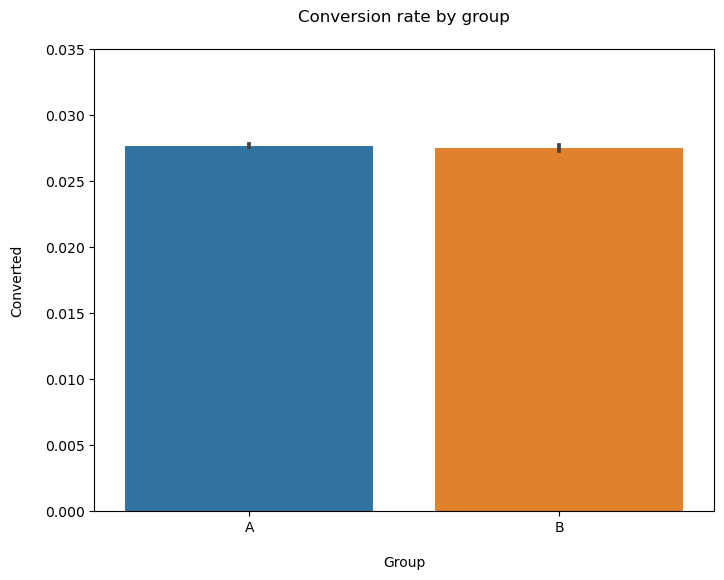

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=assignment['abtest_group'], y=assignment['is_conv']) #, ci=False

plt.ylim(0, 0.035)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted', labelpad=15);

### Statistics 
In order to further give significance to these results, it is important to test the hypotesis formulated above.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
A_results = assignment[assignment['abtest_group'] == 'A']['is_conv']
B_results = assignment[assignment['abtest_group'] == 'B']['is_conv']

In [ ]:
n_A = A_results.count()
n_B = B_results.count()
successes = [A_results.sum(), B_results.sum()]
nobs = [n_A, n_B]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_A, lower_B), (upper_A, upper_B) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for group A: [{lower_A:.3f}, {upper_A:.3f}]')
print(f'ci 95% for group B: [{lower_B:.3f}, {upper_B:.3f}]')

z statistic: 1.04
p-value: 0.300
ci 95% for group A: [0.028, 0.028]
ci 95% for group B: [0.027, 0.028]


As expected, the p-value is higher than the $\alpha$ =0.05 threshold, hence it is not possible to reject the Null hypothesis $H_0$; the new experience did not perform different than the old one.

Additionally, by looking at the confidence intervals - as in the plot above - it is evident that the conversion rate of the new experience is pretty much the same to the standard. This is further proof that there is no improvement on the selling on the game!

## Game rounds analysis
To compute the average of gamerounds per player for each group:

In [ ]:
%%bigquery gamecounts
SELECT
  A.playerid, abtest_group, AVG(gameends) as game_avg
FROM
  `king-ds-recruit-candidate-722.abtest.assignment` as A INNER JOIN `king-ds-recruit-candidate-722.abtest.activity` as B on A.playerid= B.playerid
GROUP BY A.playerid, abtest_group

Downloading: 100%|██████████| 10331056/10331056 [00:07<00:00, 1364640.33rows/s]


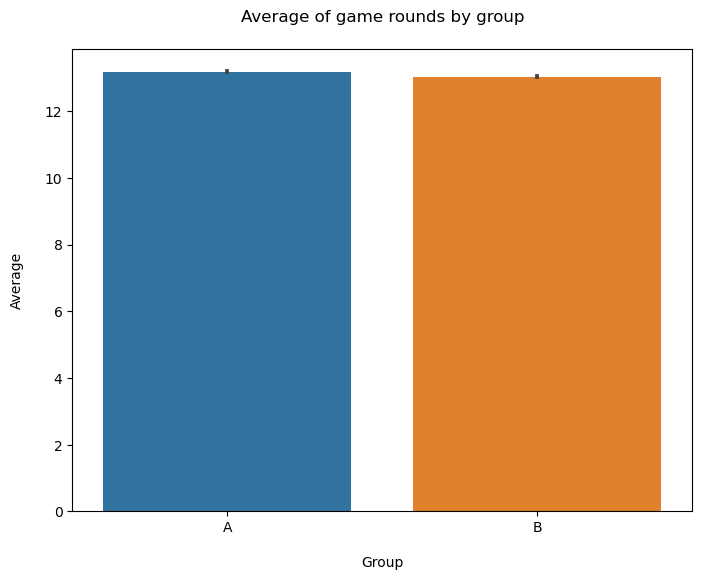

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=gamecounts['abtest_group'], y=gamecounts['game_avg']) #, ci=False

#plt.ylim(0,1)
plt.title('Average of game rounds by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Average', labelpad=15);

Results don't show a difference in the average of game rounds played by the two groups, again the new experience does not look promising. Maybe it could be useful to analyze how it behaves in the time orizon chosen.

In [ ]:
%%bigquery avg_gamecounts
SELECT
  abtest_group, activity_date, AVG(gameends) as game_avg
FROM
  `king-ds-recruit-candidate-722.abtest.assignment` as A INNER JOIN `king-ds-recruit-candidate-722.abtest.activity` as B on A.playerid= B.playerid    
GROUP BY abtest_group, activity_date, gameends

Downloading: 100%|██████████| 8509/8509 [00:01<00:00, 6849.13rows/s]


[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, '')]]

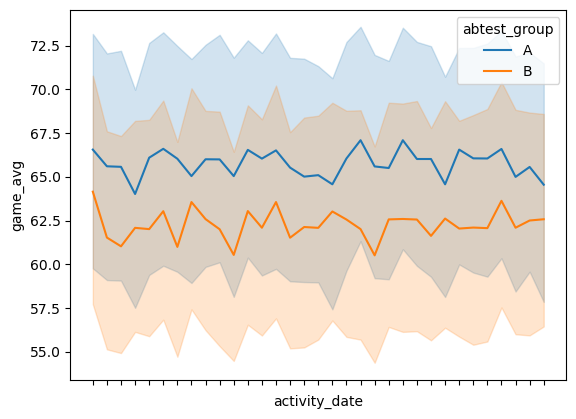

In [ ]:
g1=sns.lineplot(data=avg_gamecounts, x="activity_date", y="game_avg", hue="abtest_group")
g1.set(xticklabels=[])

## Conclusions
Finally after the test results are in, I think there are some points useful to conclude:
* Indeed, an important question when referring to A/B tests, is the preservation of metrics as the analysis is made. Metrics in this specific case are intended as the size of samples, players used, conversion dates ecc.
* The size of the samples (80% for control and 20% experiment) may have played a role in the results of the A/B test. If players are properly randomized and are reasonably independent (i.e. you don’t expect them to talk to each other about the experience that is being varied), then using unequal size groups is fine: sample means are unbiased estimators of population means, so the group size cannot introduce any bias. But at the same time - if the variances of conversion rates for A and B are similar (typically the case) - the sample size of the smaller group has more impact on the outcome than the sample size of the larger group, i.e. it drives more variance of the difference.
* Probably considering the nature of the game - simple layout, direct, comprehensible - the new experience would consists in a different design of the mobile page, maybe to make it as interactive as possible. 